In [134]:
# system stuff
import sys
import os

# the usual
import pandas as pd
import numpy as np

# cluster stuff 
from sentence_transformers import SentenceTransformer
import hdbscan # package for density based clustering 
from sklearn.preprocessing import StandardScaler

# human friendly topics
from transformers import pipeline
from keybert import KeyBERT

# dimensionality reduction
from sklearn.manifold import TSNE # good for visuals
import umap

# display stuff
import matplotlib.pyplot as plt
import seaborn as sns

# my stuff
from src.config import data_path

In [2]:
df = pd.read_csv(data_path)
labels_original = list(df.columns)
df.columns = [x.lower().replace(' ','_') for x in df.columns]

In [3]:
df.head()

,response,data_scientist,data_engineer,data_analyst,ml_engineer,other
0,"ML Ops Specialist, ML Engineer",1,0,0,1,0
1,Analytics Consultant (at least that's what my ...,0,0,1,0,0
2,System Administrator,0,0,0,0,1
3,IT Support Specialist,0,0,0,0,1
4,"ML Engineer, ML Ops Specialist, Big Data Engin...",1,1,0,1,0


In [4]:
# load an embedding model to translate the text to vectors
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# generate embeddings
embeddings = embedding_model.encode(df.response, show_progress_bar=True)

Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

In [5]:
# normalize embeddings for better clustering results
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(embeddings)

In [13]:
# reduce dimensionality before clustering
umap_reducer = umap.UMAP(
    n_components=10,
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean'
)

reduced_embeddings = umap_reducer.fit_transform(normalized_embeddings)

C:\Users\lfredric\miniconda3\envs\ds-env\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [23]:
# Run a density based clustering algorithm
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=100,
    min_samples=100,
    cluster_selection_epsilon=1.0,
    metric='euclidean',
    cluster_selection_method='eom',
    core_dist_n_jobs=-1
)

df['cluster'] = clusterer.fit_predict(reduced_embeddings)

In [24]:
df.head()

,response,data_scientist,data_engineer,data_analyst,ml_engineer,other,cluster
0,"ML Ops Specialist, ML Engineer",1,0,0,1,0,-1
1,Analytics Consultant (at least that's what my ...,0,0,1,0,0,-1
2,System Administrator,0,0,0,0,1,12
3,IT Support Specialist,0,0,0,0,1,23
4,"ML Engineer, ML Ops Specialist, Big Data Engin...",1,1,0,1,0,54


In [25]:
df.cluster.value_counts().reset_index().sort_values(by='cluster')

,cluster,count
0,-1,15353
57,0,110
32,1,612
50,2,207
49,3,208
21,4,675
41,5,230
19,6,684
26,7,661
43,8,228


In [18]:
# check them out in 2D space using TSNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings_tsne = tsne.fit_transform(normalized_embeddings)

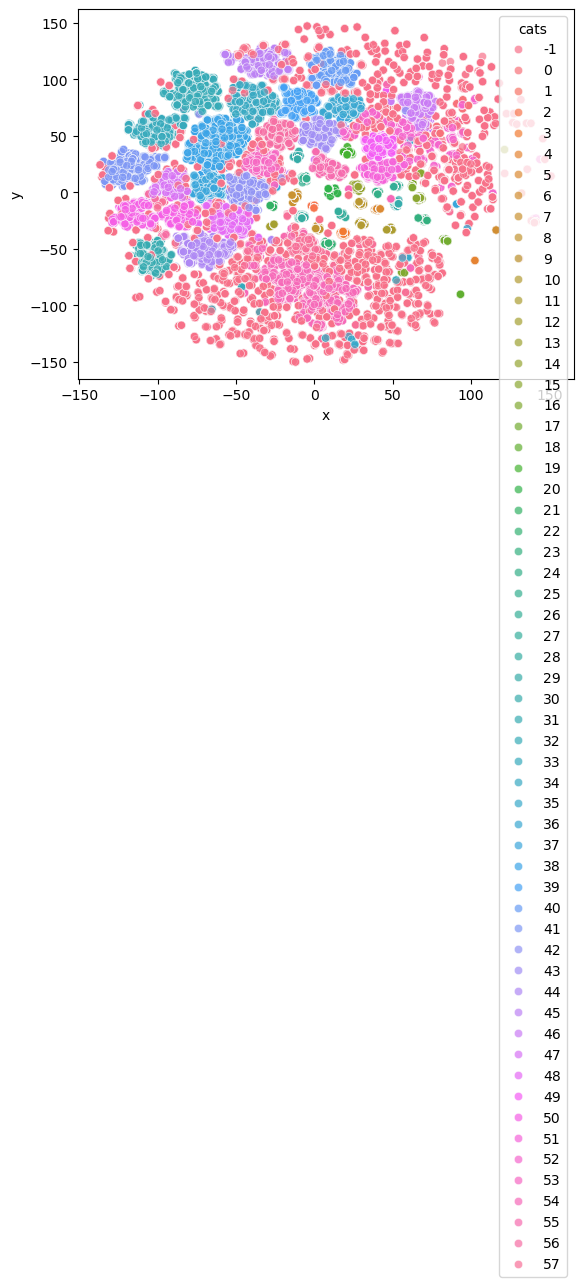

In [131]:
# Plot
df_plot = pd.DataFrame(reduced_embeddings_tsne, columns = ['x','y'])
df_plot['cats'] = df.cluster.astype('category')

sns.scatterplot(df_plot, x='x', y='y', hue='cats', alpha=0.7)
plt.show()

In [83]:
# create some human legible cluster names 
summarizer = pipeline('summarization', model='facebook/bart-large-cnn')

In [127]:
def truncate_text(text, max_model_length=1023):
    tokenized_text = summarizer.tokenizer(text, return_tensors='pt', truncation=True, max_length=max_model_length)
    return summarizer.tokenizer.decode(tokenized_text['input_ids'][0], skip_special_tokens=True)

def create_cluster_labels_llm(
    df, 
    chunk_size=50, 
    max_model_length=1023 # truncate texts that are too long
):
    cluster_labels = {}
    n_clusters = len(df['cluster'].unique())
    for cluster_i, cluster in enumerate(df['cluster'].unique()):
        # get only the responses associated with a given cluster
        cluster_texts = df[df['cluster']==cluster]['response'].tolist()
        
        chunk_summaries = []
        # LLMs typically have 1024-2048 char limits, so chunking each cluster and then summarizing the summaries
        n_texts = len(cluster_texts)
        n_chunks = int(n_texts/chunk_size) + 1
        for chunk_i, i in enumerate(range(0, len(cluster_texts), chunk_size)):
            print(f'Summarizing Cluster {cluster_i+1:03,}/{n_clusters:03,} --- Completing Chunk {chunk_i+1:04,}/{n_chunks:04,}', end='\r')
            chunk = " ".join(cluster_texts[i: i+chunk_size])
            summary = summarizer(truncate_text(chunk, max_model_length), max_length=30, min_length=1, do_sample=False)[0]['summary_text']
            chunk_summaries.append(summary)
            
        
        final_summary = summarizer(
            truncate_text(" ".join(chunk_summaries)), 
            max_length=20, min_length=1, do_sample=False)[0]['summary_text']
        cluster_labels[cluster] = final_summary
        
    return cluster_labels

In [128]:
cluster_labels = create_cluster_labels_llm(df)

Your max_length is set to 30, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Your max_length is set to 30, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Your max_length is set to 30, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Your max_length is set to 30, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Your max_length is set to 30, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Your max_length is set to 30, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Your max_length is set to 30, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Your max_length is set to 30, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Your max_length is set to 30, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Your max_length is set to 30, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Your max_length is set to 30, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Your max_length is set to 30, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


In [129]:
df['cluster_label'] = df['cluster'].map(cluster_labels)

In [160]:
# keyword method of creating topics

# Load KeyBERT for keyword extraction
kw_model = KeyBERT(embedding_model)

def create_cluster_labels_keyword(
    df, 
    chunk_size=50, 
    max_model_length=1023 # truncate texts that are too long
):
    cluster_labels = {}
    n_clusters = len(df['cluster'].unique())
    for cluster_i, cluster in enumerate(df['cluster'].unique()):
        print(f'Completing Cluster {cluster_i:03,}/{n_clusters:03,}', end='\r')
        # get only the responses associated with a given cluster
        cluster_texts = df[df['cluster']==cluster]['response'].tolist()
        
        joined_text = " ".join(cluster_texts)
        keywords = kw_model.extract_keywords(joined_text, keyphrase_ngram_range=(1,2), stop_words='english', top_n=5)
        cluster_labels[cluster] = ", ".join([kw[0] for kw in keywords])
        
    return cluster_labels

In [161]:
cluster_labels = create_cluster_labels_keyword(df)

In [162]:
df['cluster_keyword'] = df['cluster'].map(cluster_labels)

In [164]:
df.groupby(['cluster', 'cluster_label', 'cluster_keyword']).apply(lambda x: x.sample(5))

response  \
cluster cluster_label                                      cluster_keyword                                                                                               
-1      I used to like being a System Administrator, bu... career devops, data engineer, careers devops, a... 49302  I work as a Database Administrator, but it's e...   
                                                                                                              27405                                         HR Manager   
                                                                                                              22994               Big Data Engineer, ML Ops Specialist   
                                                                                                              12758  Officially, a Business Intelligence Analyst, b...   
                                                                                                              13933                        Data Engineer, Data Analyst   
...                                                                                                                                                                ...   
 57     Being a Big Data Engineer, Business Intelligenc... data engineer, analyst dream, intelligence anal... 13135  Being a Analytics Consultant, Machine Learning...   
                                                                                                              31689    ML Ops Specialist, ETL Developer, AI Researcher   
                                                                                                              3727   Being a Machine Learning Specialist, ETL Devel...   
                                                                                                              3639   Being a Machine Learning Engineer, Analytics C...   
                                                                                                              4729         Being a AI Researcher is a dream come true.   

                                                                                                                     data_scientist  \
cluster cluster_label                                      cluster_keyword                                                            
-1      I used to like being a System Administrator, bu... career devops, data engineer, careers devops, a... 49302               0   
                                                                                                              27405               0   
                                                                                                              22994               0   
                                                                                                              12758               0   
                                                                                                              13933               0   
...                                                                                                                             ...   
 57     Being a Big Data Engineer, Business Intelligenc... data engineer, analyst dream, intelligence anal... 13135               1   
                                                                                                              31689               1   
                                                                                                              3727                1   
                                                                                                              3639                1   
                                                                                                              4729                1   

                                                                                                                     data_engineer  \
cluster cluster_label                                    